<a href="https://colab.research.google.com/github/yuncaich/TFG_Proyect/blob/main/Codigo_TFG/MedMNIST_Segmentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
pip install SimpleITK


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.2 MB/s 


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from skimage import io
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.utils.data as data
from PIL import Image

import torchvision.transforms as transforms
import torch.nn.functional as F
from collections import defaultdict
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from matplotlib import pyplot as plt
from torch.utils.data import WeightedRandomSampler
import os
import cv2


<h1> Cargar datos

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001
url_imagen = "/content/drive/MyDrive/Segmentacion/Imagen_Seccionado_128x128"
url_label = "/content/drive/MyDrive/Segmentacion/Label_Seccionado_128x128"
url_imagen_test= "/content/drive/MyDrive/Segmentacion/Imagenes_test_128x128"
url_label_test = "/content/drive/MyDrive/Segmentacion/Label_test_128x128"

In [ ]:
class ImagesCustomDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir_images, root_dir_label, transform=None):
        self.transform = transform
        volumes = list(filter(lambda x: True if 'volume-' in x else False, os.listdir(root_dir_images)))
        self.data = []
        self.targets = []
        for volume_id in volumes:
          img_dir = os.path.join(root_dir_images, volume_id)
          target_dir = os.path.join(root_dir_label, volume_id)
          samples = list(map(lambda x: os.path.join(img_dir, x), sorted(os.listdir(img_dir))))
          labels = list(map(lambda x: os.path.join(target_dir, x), sorted(os.listdir(target_dir))))

          self.data.extend(samples)
          self.targets.extend(labels)

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        target = np.load(self.targets[idx])
        if self.transform:
          img=self.transform(img)

        return (img, target)

In [ ]:
'''transform = transforms.Compose([ transforms.Resize((64,64)),
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])'''

transform = transforms.Compose([
            transforms.ToTensor()
          ])



dataset = ImagesCustomDataset(url_imagen,url_label, transform=transform)
train_dataset,train_dataset_eval = torch.utils.data.random_split(dataset,[11082,5000])

# encapsulate data into dataloader form

dataloaders = {
    'train': data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': data.DataLoader(dataset=train_dataset_eval, batch_size=2*BATCH_SIZE, shuffle=True)
}

'''
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=True)'''

283


([], <a list of 0 Text major ticklabel objects>)

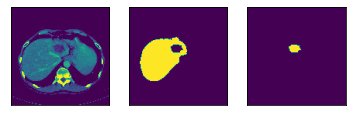

In [ ]:
prueba = ImagesCustomDataset("/content/drive/MyDrive/Segmentacion/Imagenes_test_128x128","/content/drive/MyDrive/Segmentacion/Label_test_128x128")

idx = np.random.randint(len(prueba))
x,y = prueba[idx]

plt.xticks([])
plt.yticks([])
plt.imshow(x)
plt.subplot(1,3,1)
plt.xticks([])
plt.yticks([])
plt.imshow(x)
plt.subplot(1,3,2)
plt.xticks([])
plt.yticks([])
plt.imshow(y[0])
plt.subplot(1,3,3)
plt.imshow(y[1])
plt.xticks([])
plt.yticks([])

<h1> UNET Modelo

In [ ]:
class UNetEncode(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.encode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)
        )

        self._result = None

    def forward(self, x):
        self._result = self.encode(x)
        return self._result

    def getResult(self):
        return self._result

In [ ]:
class UNetDecode(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=True, kaiming_initialization=False):
        super().__init__()

        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        return self.decode(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, output_channels, input_channels=3):
        super().__init__()
        
        #TODO!!
        self.encode_lvl_0 = UNetEncode(input_channels, 64)
        self.encode_lvl_1 = UNetEncode(64, 128)
        self.encode_lvl_2 = UNetEncode(128, 256)
        self.encode_lvl_3 = UNetEncode(256, 512)
        self.encode_lvl_4 = UNetEncode(512, 1024)

        self.decode_lvl_4 = UNetDecode(1024, 1024) #Bottleneck
        self.decode_lvl_3 = UNetDecode(512 + 1024, 512)
        self.decode_lvl_2 = UNetDecode(256 + 512, 256)
        self.decode_lvl_1 = UNetDecode(128 + 256, 128)
        self.decode_lvl_0 = UNetDecode(64 + 128, 64)
        
        self.output = nn.Conv2d(64, output_channels, 1)
        
    def forward(self, x):
        # Encode
        x = self.encode_lvl_0(x)
        x = self.encode_lvl_1(x)
        x = self.encode_lvl_2(x)
        x = self.encode_lvl_3(x)
        x = self.encode_lvl_4(x)

        # Decode
        x = self.decode_lvl_4(x)
        x = torch.cat([x, self.encode_lvl_3.getResult()], dim=1)
        x = self.decode_lvl_3(x)
        x = torch.cat([x, self.encode_lvl_2.getResult()], dim=1)
        x = self.decode_lvl_2(x)
        x = torch.cat([x, self.encode_lvl_1.getResult()], dim=1)
        x = self.decode_lvl_1(x)
        x = torch.cat([x, self.encode_lvl_0.getResult()], dim=1)
        x = self.decode_lvl_0(x)
        
        # Output
        return self.output(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_classes = 2

model = UNet(n_classes, 1).to(device)




<h1>Loss Function</h1>


In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def iou_loss(pred, target, smooth = 1e-4):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2)
      
    loss = (1 - ((intersection + smooth) / (union + smooth)))
    
    return loss.mean()

    
def tversky_index(pred, target, alpha , beta,smooth = 1e-4):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2)

    X_Y = pred.sum(dim=2).sum(dim=2) - intersection
    Y_X = target.sum(dim=2).sum(dim=2) - intersection

    loss = (1 - (intersection + smooth)/ ((intersection + smooth) + alpha * X_Y + beta * Y_X))
    
    return loss.mean()

In [ ]:
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm

def calc_loss_dice(pred, target, metrics, bce_weight=0.1):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    #loss = bce * bce_weight + dice * (1 - bce_weight)
    loss = bce * bce_weight + dice
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def calc_loss_iou(pred, target, metrics, bce_weight=0.1):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    iou = iou_loss(pred, target)
    
    #loss = bce * bce_weight + dice * (1 - bce_weight)
    loss = bce * bce_weight + iou
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['iou'] += iou.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def calc_loss_tversky(pred, target, metrics, bce_weight=0.1):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    # Alpha, beta values (https://arxiv.org/pdf/1810.07842v1.pdf)
    alpha=.7
    beta=.3
    tversky = tversky_index(pred, target, alpha , beta)
    
    #loss = bce * bce_weight + dice * (1 - bce_weight)
    loss = bce * bce_weight + tversky
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['tversky'] += tversky.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)        

                optimizer.zero_grad()

 
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss_dice(outputs, labels, metrics)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            scheduler.step()

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

<h1>Test

In [ ]:
test_dataset = ImagesCustomDataset(url_imagen_test,url_label_test,transform=transform)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=300, shuffle=False)

In [ ]:
import os
import cv2
from os import mkdir

def test_datasets(test_loader,model):
  batch_predictions = []
  model.eval()
  dice_loss_list = []
  tversky_loss = []
  iou_loss_list = []
  with torch.no_grad():
    for idx, (inputs,labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      pred = model(inputs)
      pred = torch.sigmoid(pred)
      pred = pred[:,1,:,:].unsqueeze(dim=1)
      labels = labels[:,1,:,:].unsqueeze(dim=1)
      iou_loss_list.append(iou_loss(pred,labels).cpu())
      dice_loss_list.append(dice_loss(pred, labels).cpu())
      #accuracy.append(accuracy_score(labels.cpu(),pred.cpu()))
      batch_predictions.append(pred.cpu())

      # np.save("/content/drive/MyDrive/Resultados_Segmentacion/iou" ,pred.cpu().numpy())
      # np.save("/content/drive/MyDrive/Input_resultado/iou" , inputs.cpu().numpy())
      # np.save("/content/drive/MyDrive/label_resultado/iou" , labels.cpu().numpy())



      
  return np.array(dice_loss_list).mean() , np.array(iou_loss_list).mean()
  

In [ ]:
model = torch.load('/content/drive/MyDrive/Segmentacion/unet_tversky.pth')

dice,tversky = test_datasets(test_loader,model)



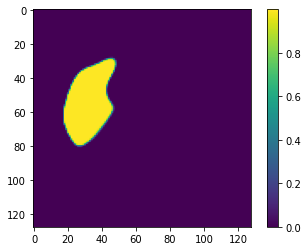

In [ ]:
import matplotlib.pyplot as plt

t = np.load("/content/drive/MyDrive/Resultados_Segmentacion/tversky.npy", allow_pickle=True)
i = np.load("/content/drive/MyDrive/Resultados_Segmentacion/iou.npy", allow_pickle=True)
d = np.load("/content/drive/MyDrive/Resultados_Segmentacion/dice.npy", allow_pickle=True)

inputs = np.load("/content/drive/MyDrive/Input_resultado/tversky.npy", allow_pickle=True)
labels = np.load("/content/drive/MyDrive/label_resultado/tversky.npy", allow_pickle=True)

plt.imshow(i[174][0])
plt.colorbar()



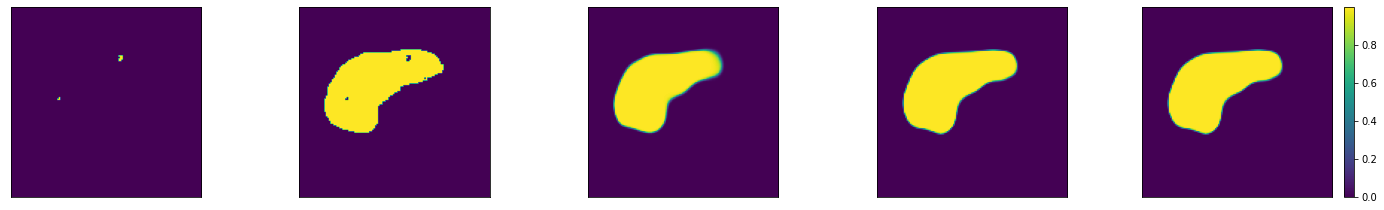

In [ ]:
plt.figure(figsize=(25, 3.5))
plt.subplot(1,5,1)
plt.xticks([])
plt.yticks([])
plt.imshow(labels[237][1])
plt.subplot(1,5,2)
plt.xticks([])
plt.yticks([])
plt.imshow(labels[237][0])
plt.subplot(1,5,3)
plt.xticks([])
plt.yticks([])
plt.imshow(t[237][0])
plt.subplot(1,5,4)
plt.xticks([])
plt.yticks([])
plt.imshow(i[237][0])
plt.subplot(1,5,5)
plt.xticks([])
plt.yticks([])
plt.imshow(d[237][0])
plt.colorbar()


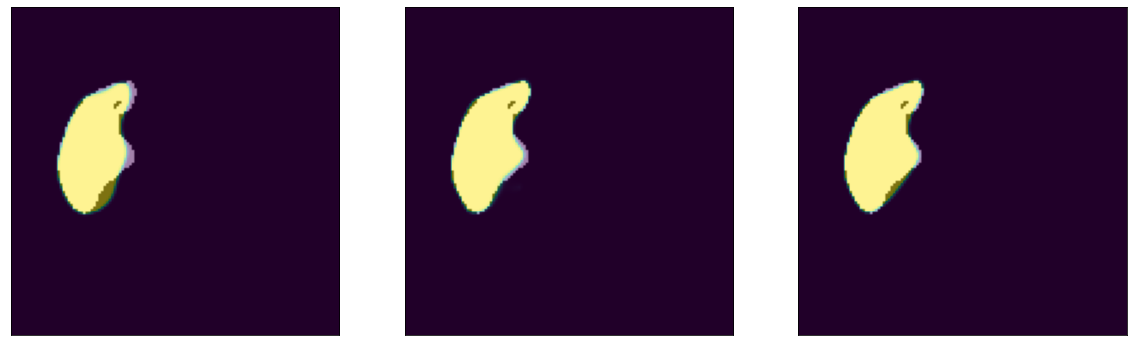

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.xticks([])
plt.yticks([])
plt.imshow(labels[174][0],cmap="gray")
plt.imshow(t[174][0],alpha=0.5)
plt.subplot(1,3,2)
plt.xticks([])
plt.yticks([])
plt.imshow(labels[174][0],cmap="gray")
plt.imshow(i[174][0],alpha=0.5)
plt.subplot(1,3,3)
plt.xticks([])
plt.yticks([])
plt.imshow(labels[174][0],cmap="gray")
plt.imshow(d[174][0],alpha=0.5)






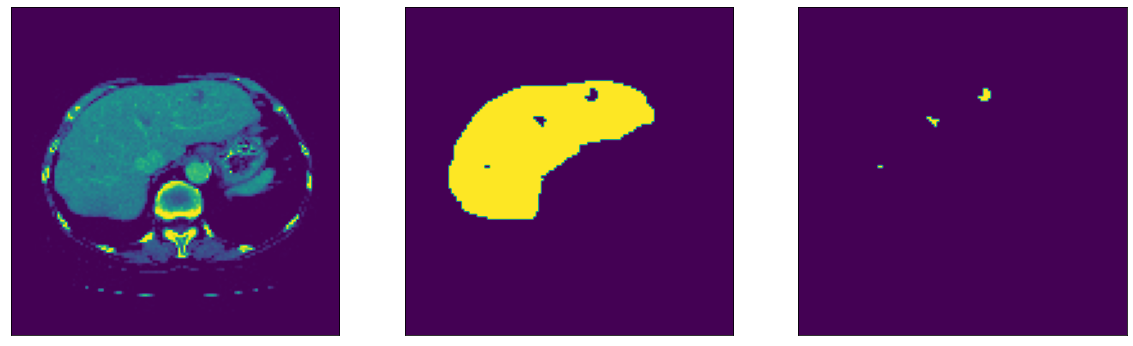

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.xticks([])
plt.yticks([])
plt.imshow(inputs[238][0])
plt.subplot(1,3,2)
plt.xticks([])
plt.yticks([])
plt.imshow(labels[238][0])
plt.subplot(1,3,3)
plt.xticks([])
plt.yticks([])
plt.imshow(labels[238][1])

In [ ]:
# for i in range(pred.shape[0]):

#   plt.imsave("/content/drive/MyDrive/Tversky_pred[i][1]/"+ str(cont),pred[i][1],format="jpg")
#   cont = cont +1

# cont=0

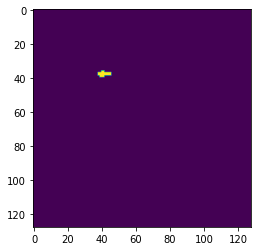

In [ ]:
plt.imshow(labels[175][1])

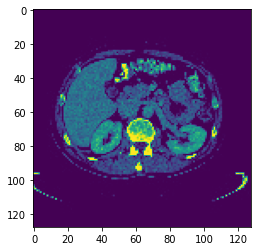

In [ ]:
plt.imshow(inputs[175][0])

In [ ]:
dice

0.09985885121519078

In [ ]:
tversky

0.1262529890876734